In [1]:
import os

from sklearn.cluster import HDBSCAN
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from langchain_core.messages import SystemMessage
from langchain_core.prompts import (
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate
)

# Import Azure OpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain_openai import AzureChatOpenAI

from dotenv import load_dotenv

from collections import Counter

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../../")
from reclaim_tiktok.classifier.classifier import Classifier

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import textwrap

In [4]:
# Construct an absolute path to where your .env file is located
dotenv_path = os.path.join(os.getcwd(), '.env')
result = load_dotenv(dotenv_path)
print(result)  # This should print True if the file is loaded successfully

False


In [5]:
embeddings_client = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-small-eastus",
    openai_api_version="2024-02-01",
)

llm_client = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_deployment="gpt-35-turbo-16k",
)

## Get data and embed

In [6]:
path_csv= "../../data/"

df = pd.read_csv(path_csv+'tiktok_videos_based_on_hashtags_cleaned_transcribed.csv')

In [7]:
path_csv= "../../data/"

df = pd.read_csv(path_csv+'tiktok_videos_based_on_hashtags_cleaned_transcribed.csv')
# Filter out videos with the same video_id
df = df.drop_duplicates(subset=['video_id'])
# Filter out videos without transcript
df = df.dropna(subset=['german_transcript'])

In [8]:
docs_classifier = [
   str(df["video_description"][a]) + "\n\n" +  str(df["suggested_words"][a]) +"\n\n" +  str(df["german_transcript"][a])
    for a in df.index
]

In [9]:
#embeddings_classifier = embeddings_client.embed_documents(docs_classifier)
#embeddings_classifier=np.array(embeddings_classifier)
#np.save(path_csv+"/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed_classifier.npy", embeddings_classifier)
embeddings_classifier=np.load(path_csv+"/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed_classifier.npy")

## Clean the data

Take only those classified right

In [10]:
right_classifier = Classifier(classifier_path="../../data/classifier/")
result= right_classifier.right_wing_classifier_f_embeddings(docs_classifier, embeddings_classifier, embeddings_client)
condition=result=="right"
df_clean=df[:][condition]

Filter out the videos with the same text/audio 

In [12]:
embeddings_clean = embeddings_client.embed_documents(np.array(df_clean.german_transcript))

In [13]:
# Calculate cosine similarity between embeddings
similarities = cosine_similarity(embeddings_clean)

# Keep track of videos to remove
videos_to_remove = set()

# Iterate through the upper triangular part of the similarity matrix
all_similar=[]
for i in range(len(similarities)):
    similar_videos = np.where((similarities[i] > 0.95))[0]
    if len(similar_videos) > 1:
        all_similar.append(list(similar_videos))
        # If there are similar videos, keep the one with the smallest index
        keep_video = min(similar_videos)
        videos_to_remove.update(set(similar_videos) - {keep_video})

In [14]:
videos_to_remove_index=np.array(df_clean.index)[list(videos_to_remove)]
# Remove similar videos
df_clean_double = df_clean[~df_clean.index.isin(videos_to_remove_index)]
embeddings_clean_double=np.delete(embeddings_clean,list(videos_to_remove), axis=0)

Display three videos which are most popular

In [16]:
def merge_lists(lists):
    result = []
    for l in lists:
        new_set = set(l)
        found = False
        for i in range(len(result)):
            if new_set & result[i]:
                result[i] |= new_set
                found = True
                break
        if not found:
            result.append(new_set)
    return [list(s) for s in result]

all_similar_unique_entries = sorted([list(entry) for entry in all_similar])

unique_entries_merged=merge_lists(all_similar_unique_entries)
transcript_list=[np.array(df_clean["german_transcript"])[li_sim[0]] for li_sim in unique_entries_merged]
playcount_list=[ np.array(df_clean["video_playcount"])[li_sim] for li_sim in unique_entries_merged]
playcount_list_sum=[ sum(np.array(df_clean["video_playcount"])[li_sim]) for li_sim in unique_entries_merged]
most_popular_vid=[np.array(df_clean["video_id"])[li_sim] for li_sim in unique_entries_merged]

for ncount in range(1,4):
    most_popular_narr=np.argsort(playcount_list_sum)[-ncount]
    most_popular_video=np.argmax(playcount_list[most_popular_narr])
    print(str(ncount) +". popular viral audio")
    print(transcript_list[most_popular_narr])
    print(str(playcount_list_sum[most_popular_narr]) +" views")
    print("Example video "+ str(most_popular_vid[most_popular_narr][most_popular_video]) + " with a reach of " + str(playcount_list[most_popular_narr][most_popular_video]))
    print("\n")

1. popular viral audio
falls sie in einem Land leben in dem sie für das Fischen ohne Anglerschein bestraft werden jedoch nicht für den illegalen Grenzübertritt ohne gültigen Reisepass dann haben sie das volle Recht zu sagen dieses Land wird von Idioten regiert 
6123955 views
Example video 7259813032321092891 with a reach of 6056046


2. popular viral audio
Sie haben Aus Deutschland 1 Land gemacht, dass sich Aus der Riege der ernstzunehmenden Nationen verabschiedet und als Industrieland abschafft ihre Energiewirtschaft zur migrationspolitik wird vom Rest der Welt nur noch als abschreckendes Beispiel gesehen. Selbst für unseren nominellen Verbündeten sind wir vor allem Geldautomat und Waffenlieferant in 1 Kriegsgebiet, während unsere eigene Armee die Fähigkeit zur landesverteidigung verloren hat. Warum sollten andere auch Respekt haben vor einer Regierung, der man ohne aufbegehren die vitale Infrastruktur wie die Nord Stream erdgasleitung vor der Nase wegsprengen kann? Und wenn demnächst

## Produce core messages for transcripts longer than 800

In [17]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "Du bist ein Experte im Schreiben. Du hilfst mir, die Kernaussagen aus den Transcripts von TikTokVideos zu ziehen."
            )
        ),
        HumanMessagePromptTemplate.from_template("Ziehe aus dem folgenden deutschen Transkript von einem Tiktok-Videos eine möglichst kurze Beschreibung bestehend aus maximal drei und nur maximal drei kurzen und prägnanten Kernaussagen, ohne Titel, starte direkt mit den Kernaussagen. Maximal 8 Wörter pro Kernaussage: \n\nPOSTS:{posts}\n\nTOPIC TITLE:"),
    ]
)

In [18]:
df_clean_double["core_message"]=pd.Series(dtype='str')

/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/4283752254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"]=pd.Series(dtype='str')


In [19]:
# produce core message
for ind in range(len(df_clean_double)):
    try:
        sentence=df_clean_double["german_transcript"].iloc[ind]
        if len(sentence)>800:
            print(ind)
            prompt = chat_template.format_messages(posts=sentence)
            result=llm_client.invoke(prompt).content
            df_clean_double["core_message"].iloc[ind] = result
    except Exception as e:
        print(f"Error processing index {ind}: {e}")
        continue

0


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


6


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


7


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


8


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


9


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


10


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


11


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


14


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


15


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


16


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


19


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


20


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


23


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


25


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


26


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


28


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


31


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


32


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


34


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


35


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


37


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


39


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


45


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


46


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


47


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


48


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


49


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


51


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


52


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


54


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


56


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


59


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


60


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


63


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


64


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


65


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


69


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


70


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


71


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


73


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


74


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


76


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


77


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


79


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


80


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


81


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


85


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


86


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


88


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


91


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


92


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


93


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


94


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


96


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


98


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


99


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


101


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


102


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


103


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


104


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


105


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


106


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


107


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


110


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


111


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


112


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


113


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


115


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


116


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


119


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


120


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


121


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


122


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


124


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


125


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


126


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


127


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


128


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


129


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


130


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


131


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


134


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


135


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


137


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


138


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


141


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


143


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


144


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


145


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


146


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


147


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


150


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


151


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


152


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


153


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


154


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


156


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


157


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


158


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


164


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


165


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


166


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


167


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


168


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


169


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


175


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


176
Error processing index 176: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'medium'}}}}}
177


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


179


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


180


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


182


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


184


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


185


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


186


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


187


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


189


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


190


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


191


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


192


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


193


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


196


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


197


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


198


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


201


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


202


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


203


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


205


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


206


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


207


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


208


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


209


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


210


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


211


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


212


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


213


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


214


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


215


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


218


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


221


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


222


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


223


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


224


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


225


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


226


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


228


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


230


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


231


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


232


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


234


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


235


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


236


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


238


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


239


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


240


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


242


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


245


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


246


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


247


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


248


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


249


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


251


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


253


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


261


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


263


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


264


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


267


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


268


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


269


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


270


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


271


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


272


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


273


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


274


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


275


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


277


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


279


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


280


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


281


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


283


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


284


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


285


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


286


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


287


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


289


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


290


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


293


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


294


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


296


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


300


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


301


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


302


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


303


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


306


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


307


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


309


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


310


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


311


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


312


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


313


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


316


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


318


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


321


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


322


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


323


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


325


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


328


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


329


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


331


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


332


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


333


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


335


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


336


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


338


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


339


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


340


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


342


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


345


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


346


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


347


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


348


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


354


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


355


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


358


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


359


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


361


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


362


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


363


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


364


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


366


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


368


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


369


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


371


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


376


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


377


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


379


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


381


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


383


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


384


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


385


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


387


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


388


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


389


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


390


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


391


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


393


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


394


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


395


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


400


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


403


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


405


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


406


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


410


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


411


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


412


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


413


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


415


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


417


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


418


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


419


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


421


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


422


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


423


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


424


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


429


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


430


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


432


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


433


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


435


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


436


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


437


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


439


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


441
Error processing index 441: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
442


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


443


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


444


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


445


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


446


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


447


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


449


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


450


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


452


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


453


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


455


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


456


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


457


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


458


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


459


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


460


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


461


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


462


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


463


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


464


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


465


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


466


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


468


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


470


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


471


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


472


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


473


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


474


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


475


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


476


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


479


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


480


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


481


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


482


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


485


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


487


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


488


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


489
Error processing index 489: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
490


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


492


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


493


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


494


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


496


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


497


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


500


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


501


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


503


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


504


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


505


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


506


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


507


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


508


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


510


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


511


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


512


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


515


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


516


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


517


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


519


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


520


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


521


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


522


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


524


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


526


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


527


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


528


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


530


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


531


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


534


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


537


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


538


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


542


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


543


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


544


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


546


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


549
Error processing index 549: Azure has not provided the response due to a content filter being triggered
550


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


552


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


553


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


554


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


555


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


556


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


557


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


558


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


559


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


560


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


561


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


564


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


566


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


567


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


568


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


569


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


570


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


571


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


573


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


574


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


575


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


576


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


577


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


580


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


581


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


583


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


584


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


585


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


586


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


590


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


591


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


592


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


595


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


597


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


599


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


601


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


604


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


608


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


609


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


610


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


612


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


614


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


615


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


619


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


621


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


622


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


623


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


624


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


625


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


626


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


627


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


628


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


629


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


630


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


632


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


634


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


635


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


638
Error processing index 638: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
639


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


640
Error processing index 640: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'medium'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
642


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


643


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


644


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


645


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


646


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


647


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


648


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


649


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


650


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


653


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


655


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


657


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


658


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


659


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


661


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


662


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


665


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


668


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


671


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


672


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


673


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


674


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


675


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


680


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


681


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


682


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


683


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


684


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


685


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


686


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


687


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


688


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


689


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


690


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


691


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


692


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


693


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


695


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


698


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


699


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


701


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


702


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


704


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


706


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


708


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


710


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


712


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


713


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


716


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


717


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


719


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


720


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


722


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


724


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


725


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


726


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


727


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


729


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


731


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


732


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


733


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


736


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


737


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


738


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


740


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


742


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


744


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


746


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


747


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


748


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


749


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


750


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


751


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


753


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


754


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


757


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


758


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


759


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


760


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


762


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


763


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


764


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


765


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


767


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


768


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


769


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


770


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


772


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


773


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


775


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


776


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


777


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


778


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


779


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


780


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


781


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


783


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


785


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


787


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


789


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


790


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


791


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


794


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


795


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


797


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


798


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


799


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


800


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


801


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


802


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


803


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


804


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


805


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


807


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


809


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


810


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


813


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


814


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


815


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


816


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


818


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


819


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


821


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


822


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


824


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


825


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


826


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


827


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


828


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


830


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


832


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


833


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


834


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


835


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


836


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


837


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


838


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


839


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


840


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


842


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


843


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


844


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


846


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


847


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


848


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


850


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


851


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


852


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


853


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


854


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


855


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


856


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


857


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


859


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


861


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


862


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


863


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


864


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


872


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


873


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


874


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


876


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


877


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


878


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


880


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


881


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


883


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


884


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


886


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


887


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


888


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


889


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


890


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


892


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


893


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


894


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


895


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


897


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


898


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


899


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


900


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


903


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


905


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


906


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


909


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


910


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


911


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


913


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


914


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


918


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


919


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


920


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


923


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


924


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


926


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


927


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


929


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


932


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


933


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


934


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


935


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


936


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


938


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


940


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


941


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


943


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


944


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


945


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


946


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


947


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


950


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


951


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


952


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


954


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


955


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


956


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


959


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


960


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


961


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


962


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


963


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


964


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


966


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


969


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


970


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


971


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


973


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


975


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


976


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


977


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


981


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


982


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


985


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


986


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


987


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


988


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


990


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


992


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


994


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


995


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


998


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


999


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1000


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1002


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1004


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1005


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1006


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1008


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1009


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1011


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1012


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1013


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1014


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1016


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1020


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1021


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1022


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1023


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1024


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1025


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1026


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1029


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1030


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1032


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1033


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1034


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1035


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1036


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1037


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1038


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1040


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1042


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1044


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1045


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1046


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1047


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1048


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1051


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1053


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1054


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1055


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1058


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1059


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1062


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1065


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1066


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1067


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1068


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1069


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1070


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1073


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1075


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1076


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1077


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1078


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1079


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1080


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1082


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1085


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1087


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1089


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1090


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1091


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1093


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1094
Error processing index 1094: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'medium'}}}}}
1095


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1097


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1099


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1101


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1104


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1106


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1107


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1108


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1109


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1110


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1111


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1114


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1115


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1119


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1120


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1122


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1123


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1124


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1127


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1128


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1129


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1133


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1134


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1135


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1136


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1137


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1139


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1141


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1142


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1144


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1145


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1147


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1149


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1152


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1153


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1154


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1155


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1156


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1160


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1161


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1162


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1164


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1165


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1167


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1168


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1170


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1171


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1172


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1174


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1175


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1177


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1178


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1179


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1180


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1182


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1183


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1184


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1185


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1186


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1189


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1190


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1191


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1192


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1193


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1194


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1195


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1196


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1197


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1198


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1199


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1201


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1202


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1203


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1204


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1205


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1206


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1207


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1208


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1209


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1210


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1211


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1212


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1217


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1218


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1219


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1220


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1221


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1222


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1224


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1225


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1226


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1227


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1228


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1230


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1233


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1234
Error processing index 1234: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'low'}}}}}
1235


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1236


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1237


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1239


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1240


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1241


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1242


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1243


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1244


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1246


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1247


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1248


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1249


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1251


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1252


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1253


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1254


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1256


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1257


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1258


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1259


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1260


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1261


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1263


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1265


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1266


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1267


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1268


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1269


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1271


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1272


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1273


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1274


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1277


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1278


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1279


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1280


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1282


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1284


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1285


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1286


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1287


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1288


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1289


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1290


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1292


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1294


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1295


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1297


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1298


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1299


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1300


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1301


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1302


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1303


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1304


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1306


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1307


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1308


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1310


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1313


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1316


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1318


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1319


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1321


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1322


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1325


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1326


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1328


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1329


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1330


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1331


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1332


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1333


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1334


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1337


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1338


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1341


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1343


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1344


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1345


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1347


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1348


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1349


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1352


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1353


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1354


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1358


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1359


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1360


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1362


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1363


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1364


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1366


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1368


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1372


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1373


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1375


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1376


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1377


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1381


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1382


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1383


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1384


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1388


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1390


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1392


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1393


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1396


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1397


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1398


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1399


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1400


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1403


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1406


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1407


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1409


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1410


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1411


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1413


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1419


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1420


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1421


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1423


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1427


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1428


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1429


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1431


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1432


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1433


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1434


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1435


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1438


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1440


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1441


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1443


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1449


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1450


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1451


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1452


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1453


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1454


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1456


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1457


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1458


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1460


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1462


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1463


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1464


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1466


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1467


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1468


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1471


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1472


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1474


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1477


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1479


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1481


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1482


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1485


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1486


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1488


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1491


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1492


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1495


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1496


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1497


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1498


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1499


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1501


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1503


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1504


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1507


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1508


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1509


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1510


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1511


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1513


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1514


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1515


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1519


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1520


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1522


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1525


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1526


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1527


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1528


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1529


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1530


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1533


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1534


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1535


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1537


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1539


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1540


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1541
Error processing index 1541: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
1544


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1545


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1547


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1549


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1551


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1552


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1554


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1555


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1557


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1558


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1559


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1560
Error processing index 1560: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'low'}}}}}
1561


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1564


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1566


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1567


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1568


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1569


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1570


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1572


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1573


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1578


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1579


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1580


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1582


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1583


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1585


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1588


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1589


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1590


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1591


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1594


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1595


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1596


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1597


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1598


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1599


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1600


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1601


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1602


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1603


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1604


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1605


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1606


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1608


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1609


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1611


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1614


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1617


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1618


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1619


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1622


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1624


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1625


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1626


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1628


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1630


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1631


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1632


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1634


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1635


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1636


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1638


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1639


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1640


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1642


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1643


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1645


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1646


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1647


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1648


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1649


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1650


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1651


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1652


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1653


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1654


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1655


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1656


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1657


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1661


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1663


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1664


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1666


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1670


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1671


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1672


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1673


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1675


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1677


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1678


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1680


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1681


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1682


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1685


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1687


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1688


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1692


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1695


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1697


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1699


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1700


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1701


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1702


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1705


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1706


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1711


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1712


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1714


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1715


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1716


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1717


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1718


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1719


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1720


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1722
Error processing index 1722: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
1723
Error processing index 1723: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: http

/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1725


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1726


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1730


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1733


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1734


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1737


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1739


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1741


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1742


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1743


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1744


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1747


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1748


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1751


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1753


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1756


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1758


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1760


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1761


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1762


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1763


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1766


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1768


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1769


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1770


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1771


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1774


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1775


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1776


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1777


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1778


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1779


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1783


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1785


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1786


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1787


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1788


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1793


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1794


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1795


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1796


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1797


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1798


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1800


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1802


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1803


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1804


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1805


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1806


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1807


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1809


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1811


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1814


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1815


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1817


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1818


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1822


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1823


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1824


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1826


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1827


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1828


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1829


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1833


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1834


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1835


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1836


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1837


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1839


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1840


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1841


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1842


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1845


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1849


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1850


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1851


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1858


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1861


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1862


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1863


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1864


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1865


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1867


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1868


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1870


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1871


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1876


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1881


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1882


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1884


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1886


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1888


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1889


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1891


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1893


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1894


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1895


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1897


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1900


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1903


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1904


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1905


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1906


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1908


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1911


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1913


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1917


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1921


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1922


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1923


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1926


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1927


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1930


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1931


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1934


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1937


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1944


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1945


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1946


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1948


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1950


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1951


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1952


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1954


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1955


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1956


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1957


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1958


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1961


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1962


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1964


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1967


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1968


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1969


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1970


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1974


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1979


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1980


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1983


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1984


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1986


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1988


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1989


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1990


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1991


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1992


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1993


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1994


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1997


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1998


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


1999


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2002


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2003


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2004


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2007


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2008


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2009


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2012


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2014


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2015


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2017


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2018


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2019


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2020


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2021


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2022


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2025


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2026


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2027


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2029


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2030


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2031


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2034


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2036


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2037


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2038


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2039


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2040


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2041


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2042


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2043


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2044


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2045


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2046


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2047


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2048


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2052
Error processing index 2052: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'medium'}}}}}
2053


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2054


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2055


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2058


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2059


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


2060


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/557460859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].iloc[ind] = result


In [20]:
df_clean_double["core_message"]

1       Streik in Deutschland: Züge, Autobahnen und St...
3                                                     NaN
4       Bürgergeld, Angst vor Sarah Wagenknecht, deuts...
7                                                     NaN
11                                                    NaN
                              ...                        
4917    1. Staat enteignet uns, Politiker machen nicht...
4920    1. Kritik an der aktuellen Politik der Spaltun...
4921    - Erdogan bezeichnet Israel als Terrorstaat un...
4934                                                  NaN
4937                                                  NaN
Name: core_message, Length: 2063, dtype: object

In [21]:
df_clean_double["core_message"][1]

'Streik in Deutschland: Züge, Autobahnen und Straßen gesperrt\nBauern, LKW-Fahrer und Gastronomen beteiligen sich\nUnzufriedenheit mit politischer Lage führt zu Streikbeteiligung der Bevölkerung'

In [22]:
df_clean_double["core_message"].fillna(df_clean_double["german_transcript"], inplace=True)
df_clean_double["core_message"]

/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/1942368631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].fillna(df_clean_double["german_transcript"], inplace=True)


1       Streik in Deutschland: Züge, Autobahnen und St...
3       falls sie in einem Land leben in dem sie für d...
4       Bürgergeld, Angst vor Sarah Wagenknecht, deuts...
7       wer sind sie eigentlich? hab sie noch nie gese...
11      maten Germany, das war mal 1 Begriff. die Welt...
                              ...                        
4917    1. Staat enteignet uns, Politiker machen nicht...
4920    1. Kritik an der aktuellen Politik der Spaltun...
4921    - Erdogan bezeichnet Israel als Terrorstaat un...
4934    du kennst die deutsche Außenministerin oder An...
4937    das Osterfest steht vor der Tür und damit 1 pa...
Name: core_message, Length: 2063, dtype: object

In [23]:
df_clean_double["core_message"].fillna(df_clean_double["german_transcript"], inplace=True)

df_clean_double['core_message'] = df_clean_double['core_message'].replace(r'(Kernaussage|n:|1\.|2\.|3\.)', '', regex=True).replace(r'\n', ';', regex=True)

/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/4134940910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].fillna(df_clean_double["german_transcript"], inplace=True)
/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/4134940910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double['core_message'] = df_clean_double['core_message'].replace(r'(Kernaussage|n:|1\.|2\.|3\.)', '', regex=True).replace(r'\n', ';', regex=True)


Create a new df with every line for unique core message

In [24]:

# Remove unwanted values from core_message and split by ';'
df_clean_double['core_message'] = df_clean_double['core_message'].str.split(';')

# Explode the core_message column to create a new DataFrame df_cm
df_cm= df_clean_double.explode('core_message')

# Reset index to ensure consecutive integers are used
df_cm.reset_index(drop=True, inplace=True)

/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_47139/3637657992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double['core_message'] = df_clean_double['core_message'].str.split(';')


Generate embeddings per core message

In [25]:
embeddings_cm = embeddings_client.embed_documents(df_cm["core_message"])
embeddings_cm=np.array(embeddings_cm)

# Data clustering

## Kmeans

Calculate the optimal amount of cluster

In [26]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings_cm)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

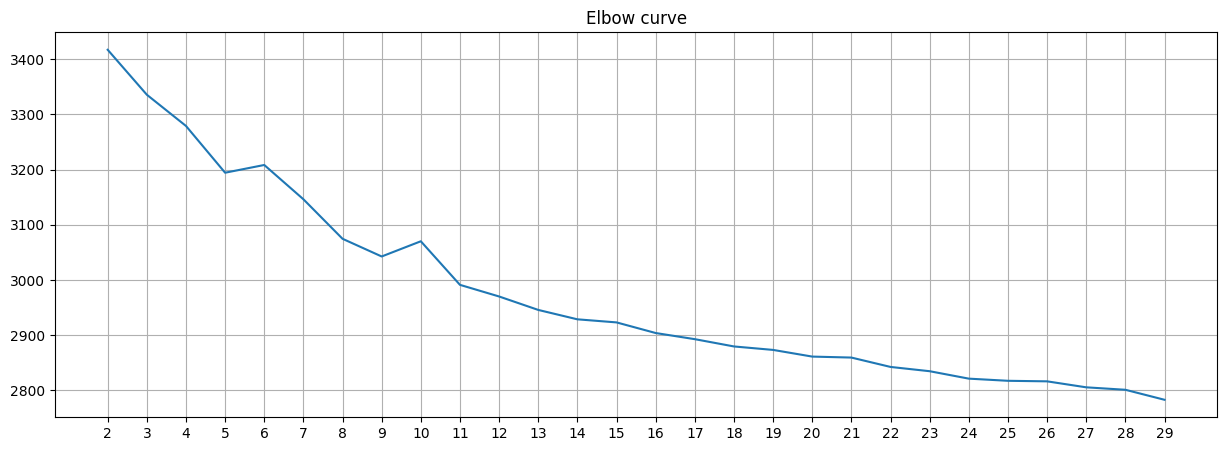

In [27]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 30), distorsions)
plt.grid(True)
plt.xticks(range(2, 30))
plt.title('Elbow curve')
#you should pick the elbow of the curve for the optimal number of clusters

In [28]:
matrix = np.vstack(embeddings_cm)
matrix.shape

(5222, 1536)

In [29]:
kmeans = KMeans(n_clusters=24, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_

In [30]:
df_cm["cluster"]=labels
Counter(labels)

Counter({0: 432,
         9: 324,
         7: 284,
         8: 271,
         13: 268,
         16: 266,
         15: 258,
         19: 257,
         3: 225,
         1: 212,
         5: 208,
         6: 199,
         11: 197,
         23: 197,
         12: 194,
         14: 191,
         4: 187,
         17: 184,
         18: 181,
         10: 180,
         2: 150,
         20: 143,
         22: 133,
         21: 81})

In [31]:
# Group df_cm by "video_id" and aggregate the clusters with ";"
cluster_groups = df_cm.groupby('video_id')['cluster'].agg(lambda x: ';'.join(map(str, x))).reset_index()

# Merge the aggregated clusters back into df_clean_double based on "video_id"
df_clean_double = pd.merge(df_clean_double, cluster_groups, on='video_id', how='left')


In [32]:
df_clean_double.to_csv(path_csv+"videos_with_core_messages_clusters.csv")

In [33]:
df_clean_double

,Unnamed: 0,video_id,video_timestamp,video_duration,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,video_is_ad,...,author_videocount,author_diggcount,author_verified,suggested_words,url,english_transcript,german_transcript,error_reason,core_message,cluster
0,1,7320578484609256736,1704455008,69,196185,68661,9390,6522042,Seit ihr dabei beim streik #streiken #streik81...,False,...,190,488,False,"['streiken', 'streik8124', 'bauernstreik', 'am...",https://www.tiktok.com/@zeitzeugengenausdemkri...,urgent breaking news! mega strike on 08.01. i...,dringende Eilmeldung! mega Streik am 08.01. in...,NaN,"[Streik in Deutschland: Züge, Autobahnen und S...",22;2;18
1,3,7259813032321092891,1690306946,25,423464,44431,11512,6056046,Alice Weidel💙🇩🇪💙 #edit #aliceweidel #deutschla...,False,...,22,135,False,"['edit', 'aliceweidel', 'deutschland', 'afd', ...",https://www.tiktok.com/@wirsinddasvolkde/video...,If they live in a country where they are penal...,falls sie in einem Land leben in dem sie für d...,NaN,[falls sie in einem Land leben in dem sie für ...,7
2,4,7317232563129552161,1703675984,61,208353,2390,5403,5817725,Fragenhagel mit Alice Weidel (AfD) #fy #foryou...,False,...,94,1354,False,"['fy', 'foryou', 'foryoupage', 'fürdich', 'für...",https://www.tiktok.com/@denzho/video/731723256...,Citizen income or basic income? Neither Are y...,Bürgergeld oder Grundeinkommen? Keins von beid...,NaN,"[Bürgergeld, Angst vor Sarah Wagenknecht, deut...",13
3,7,7325036849943022881,1705493051,40,219073,5716,9307,4858904,Antwort auf @Alena #aliceweidel #Aliceweideled...,False,...,456,21900,False,"['', 'aliceweidel', 'aliceweideledit', 'afd', ...",https://www.tiktok.com/@dieausderafd/video/732...,who are they actually? have never seen them be...,wer sind sie eigentlich? hab sie noch nie gese...,NaN,[wer sind sie eigentlich? hab sie noch nie ges...,19
4,11,7332518938451954976,1707235110,21,237869,8728,5418,3843861,Made in Germany💙 #viral #foryou #fy #afd #afdd...,False,...,94,1706,False,"['viral', 'foryou', 'fy', 'afd', 'afddeutschla...",https://www.tiktok.com/@clips_30494/video/7332...,Made in Germany. that was once 1 term. the wor...,"maten Germany, das war mal 1 Begriff. die Welt...",NaN,"[maten Germany, das war mal 1 Begriff. die Wel...",19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,4917,7339988922472205601,1708974350,59,139,19,17,515,#Duett mit @Fra Nk #breakingnews #aktuellerden...,False,...,188,17600,False,"['duett', '', 'breakingnews', 'aktuellerdennje...",https://www.tiktok.com/@nicky198809/video/7339...,NaN,der Staat enteignet uns und macht 500 oder 1.0...,NaN,"[ Staat enteignet uns, Politiker machen nichts...",12;18;12
2059,4920,7347380271265680672,1710695284,49,66,1,7,503,#Duett mit @HaRaLdBeStE #rechts #aktuellerdenn...,False,...,188,17600,False,"['duett', '', 'rechts', 'aktuellerdennje', 'de...",https://www.tiktok.com/@nicky198809/video/7347...,NaN,ich bin rechts urteilst du. und damit bist du ...,NaN,[ Kritik an der aktuellen Politik der Spaltung...,9;9;18
2060,4921,7302847678910680353,1700326732,96,65,0,12,500,NaN,False,...,109,39300,False,"['fy', 'fyp', 'foryou', 'foryoupage', 'erdogan...",https://www.tiktok.com/@talos1967.4/video/7302...,NaN,der türkische Präsident Richard taiheb Erdogan...,NaN,[- Erdogan bezeichnet Israel als Terrorstaat u...,11;11;5
2061,4934,7288696383404641568,1697031876,23,59,64,4,420,#fürunserekinder #aliceweidelmeinekanzlerin #b...,False,...,3353,31000,False,"['fürunserekinder', 'aliceweidelmeinekanzlerin...",https://www.tiktok.com/@jurgenafd/video/728869...,NaN,du kennst die deutsche Außenministerin oder An...,NaN,[du kennst die deutsche Außenministerin oder A...,15
